现在我们手头上有三国向中国出口的数据, 尝试预处理这些数据

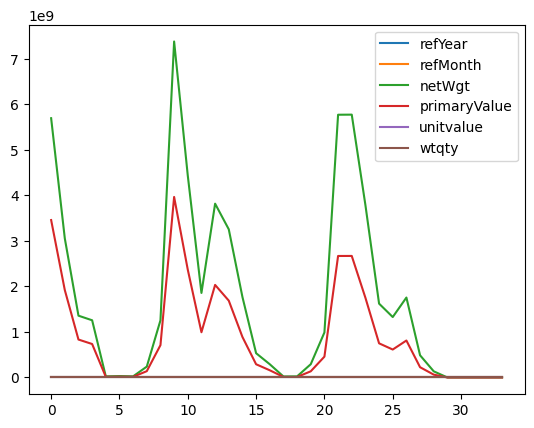

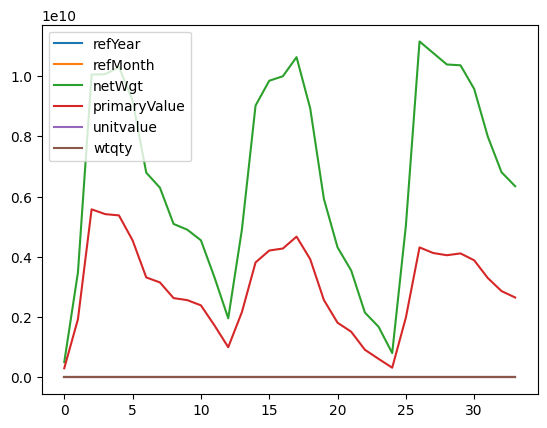

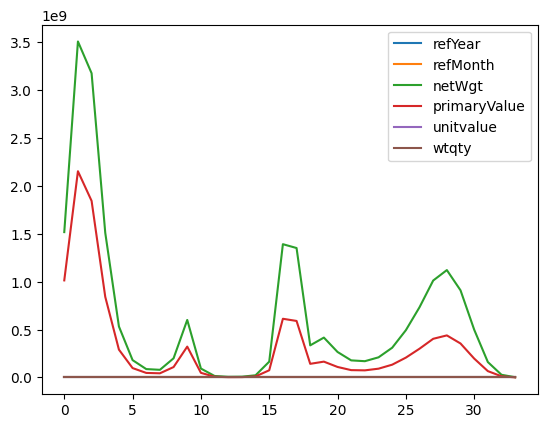

In [2]:
import pandas as pd

# convert excel to csv
df_USA = pd.read_excel(r'..\..\data\raw\Q1_refined\USA.xlsx')
df_USA.head()

# 补充缺失的数据
new_data_row = {
    'refYear': 2025,  # 请手动填写年份，例如 2025
    'refMonth': 0, # 请手动填写月份，例如 1
    'reporterISO': 'USA', # 请手动填写国家ISO代码，例如 'CHN'
    'netWgt': 0,
    'primaryValue': 0,
    'unitvalue': 0,
    'wtqty': 0
}
for i in range(6,11):
    new_data_row['refMonth'] = i
    df_USA = pd.concat([df_USA, pd.DataFrame([new_data_row])], ignore_index=True)

# 展示数据并且简单统计
df_Brazil = pd.read_excel(r'..\..\data\raw\Q1_refined\Brazil.xlsx')
df_Brazil.head()
df_Argentina = pd.read_excel(r'..\..\data\raw\Q1_refined\Argentina.xlsx')
df_Argentina.head()

df_USA.plot()
df_Brazil.plot()
df_Argentina.plot()

df_USA.to_csv(r'..\..\data\processed\Q1.USA.csv', index=False)
df_Brazil.to_csv(r'..\..\data\processed\Q1.Brazil.csv', index=False)
df_Argentina.to_csv(r'..\..\data\processed\Q1.Argentina.csv', index=False)


转化成json格式, 便于echarts作图

In [4]:
# 将三个CSV聚合为页面所需的JSON结构并保存
# 目标结构示例：
# {refMonth: '2024-01', Argentina: <净重kg>, Brazil: <净重kg>, USA: <净重kg>,
#  Argentina_cif: <金额>, Brazil_cif: <金额>, USA_cif: <金额>}

import pandas as pd
import json
from pathlib import Path

# 输入路径
p_arg = Path(r"e:\RESEARCH\APMCM\Math_Modeling_APMCM\data\processed\Q1.Argentina.csv")
p_bra = Path(r"e:\RESEARCH\APMCM\Math_Modeling_APMCM\data\processed\Q1.Brazil.csv")
p_usa = Path(r"e:\RESEARCH\APMCM\Math_Modeling_APMCM\data\processed\Q1.USA.csv")

# 输出路径
out_json = Path(r"e:\RESEARCH\APMCM\Math_Modeling_APMCM\data\processed\Q1.1.soybean_imports_quantity_price.json")

# 辅助函数：读表并统一列
def load_and_norm(path: Path, country_name: str) -> pd.DataFrame:
    # 读取CSV
    df = pd.read_csv(path)
    # 生成统一的月份字符串 YYYY-MM
    # 注意：文件中为 refYear + refMonth（数值型），需格式化为两位月
    df["Month"] = df["refYear"].astype(str) + "-" + df["refMonth"].astype(int).astype(str).str.zfill(2)
    # 选择净重与金额列（与页面一致：净重=netWgt，金额=primaryValue）
    df_norm = df[["Month", "netWgt", "primaryValue"]].copy()
    df_norm["country"] = country_name
    # 按月聚合求和（稳健处理）
    df_norm = df_norm.groupby(["Month", "country"], as_index=False).sum()
    return df_norm

# 分别读取三个国家
df_arg = load_and_norm(p_arg, "Argentina")
df_bra = load_and_norm(p_bra, "Brazil")
df_usa = load_and_norm(p_usa, "USA")

# 合并后透视为宽表：数量与金额分别透视
df_all = pd.concat([df_arg, df_bra, df_usa], ignore_index=True)

# 数量（净重kg）
qty_wide = df_all.pivot(index="Month", columns="country", values="netWgt").fillna(0.0)
# 金额（CIF）
cif_wide = df_all.pivot(index="Month", columns="country", values="primaryValue").fillna(0.0)

# 统一国家列顺序
countries = ["Argentina", "Brazil", "USA"]
qty_wide = qty_wide.reindex(columns=countries).sort_index()
cif_wide = cif_wide.reindex(columns=countries).sort_index()

# 组装为页面所需的JSON数组
records = []
for m in qty_wide.index:
    rec = {"refMonth": m}
    # 数量
    for c in countries:
        rec[c] = float(qty_wide.loc[m, c])
    # 金额
    for c in countries:
        rec[f"{c}_cif"] = float(cif_wide.loc[m, c])
    records.append(rec)

print(records)

# 保存JSON文件（UTF-8，缩进2）
out_json.parent.mkdir(parents=True, exist_ok=True)
with open(out_json, "w", encoding="utf-8") as f:
    json.dump(records, f, ensure_ascii=False, indent=2)

print(f"JSON已保存: {out_json}")
# 如需直接嵌入到HTML的JS代码，可打印：
# print("const data = " + json.dumps(records, ensure_ascii=False))

[{'refMonth': '2023-01', 'Argentina': 1515993282.53599, 'Brazil': 509677600.0, 'USA': 5693521040.0, 'Argentina_cif': 1012395719.0264, 'Brazil_cif': 305875583.0, 'USA_cif': 3456883269.0}, {'refMonth': '2023-02', 'Argentina': 3503981340.02036, 'Brazil': 3483134017.0, 'USA': 3053631893.0, 'Argentina_cif': 2150760688.03151, 'Brazil_cif': 1931031449.0, 'USA_cif': 1919323074.0}, {'refMonth': '2023-03', 'Argentina': 3172557178.85062, 'Brazil': 10042041401.0, 'USA': 1357079848.0, 'Argentina_cif': 1841480521.19693, 'Brazil_cif': 5574663441.0, 'USA_cif': 832884486.0}, {'refMonth': '2023-04', 'Argentina': 1508452358.57944, 'Brazil': 10055168341.0, 'USA': 1256087351.0, 'Argentina_cif': 840830761.283419, 'Brazil_cif': 5416095343.0, 'USA_cif': 735036906.0}, {'refMonth': '2023-05', 'Argentina': 531999999.999999, 'Brazil': 10293020511.0, 'USA': 24564000.0, 'Argentina_cif': 290432631.999999, 'Brazil_cif': 5374180072.0, 'USA_cif': 14380306.0}, {'refMonth': '2023-06', 'Argentina': 181000000.0, 'Brazil': 